In [1]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 143.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import pandas as pd

df1 = pd.read_csv("/content/goemotions_1.csv")
df2 = pd.read_csv("/content/goemotions_2.csv")
df3 = pd.read_csv("/content/goemotions_3.csv")
full_df = pd.concat([df1, df2, df3]).reset_index(drop=True)

In [3]:
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [4]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

full_df['text'] = full_df['text'].apply(preprocess_text)

In [5]:
emotion_cols = [col for col in full_df.columns if col not in ['text', 'id']]
labels = full_df[emotion_cols].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(full_df['text'], labels, test_size=0.2, random_state=42)

In [7]:
from transformers import BertTokenizer
import torch

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)
test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, y_train)
test_dataset = EmotionDataset(test_encodings, y_test)

In [16]:
from transformers import BertForSequenceClassification
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [11]:
flat_labels = np.argwhere(labels.flatten()).flatten()
class_weights = torch.tensor(
    compute_class_weight(
        'balanced',
        classes=np.unique(flat_labels),
        y=flat_labels
    ),
    dtype=torch.float
)

# Custom loss function
def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)
    loss = loss_fct(
        logits.view(-1, model.config.num_labels),
        labels.view(-1, model.config.num_labels)
    )
    return (loss, outputs) if return_outputs else loss

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(emotion_cols),
    problem_type="multi_label_classification"
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
!pip install wandb

In [13]:
import wandb
wandb.login()
wandb.init(project="emotion-classification")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kazmihiba7 (kazmihiba7-ned-university-of-engineering-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [21]:
from sklearn.utils.class_weight import compute_class_weight

In [22]:
from datetime import datetime
from transformers import Trainer, TrainingArguments

# 1. Training Arguments with proper reporting
training_args = TrainingArguments(
    output_dir='./results',
    run_name='emotion-bert-'+datetime.now().strftime("%Y-%m-%d-%H-%M"),  #
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

# Define the WeightedTrainer class inheriting from Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        return compute_loss(model, inputs, return_outputs)


# 2. Trainer initialization
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [19]:
from sklearn.metrics import hamming_loss, f1_score
import numpy as np

def compute_metrics(pred):
    """
    Compute Hamming Loss and F1 scores (micro/macro) for multi-label classification

    Args:
        pred: Trainer prediction object containing:
            - pred.predictions: Model's raw logits
            - pred.label_ids: Ground truth labels

    Returns:
        Dictionary containing metrics
    """
    # Convert logits to binary predictions (using 0.5 threshold)
    preds = (pred.predictions > 0.5).astype(int)
    labels = pred.label_ids

    # Calculate metrics
    metrics = {
        'hamming_loss': hamming_loss(labels, preds),
        'f1_micro': f1_score(labels, preds, average='micro'),
        'f1_macro': f1_score(labels, preds, average='macro'),
    }

    # Add per-class F1 scores
    f1_per_class = f1_score(labels, preds, average=None)
    for i, class_name in enumerate(emotion_cols):
        metrics[f'f1_{class_name}'] = f1_per_class[i]

    return metrics

In [26]:
class PredObject:
    def __init__(self, predictions, label_ids):
        self.predictions = predictions
        self.label_ids = label_ids

num_emotions = len(emotion_cols)

preds = np.random.rand(10, num_emotions)
labels = np.random.randint(0, 2, size=(10, num_emotions))

pred_obj = PredObject(predictions=preds, label_ids=labels)

results = compute_metrics(pred_obj)
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

hamming_loss: 0.4543
f1_micro: 0.5108
f1_macro: 0.4893
f1_author: 0.5714
f1_subreddit: 0.4000
f1_link_id: 0.8000
f1_parent_id: 0.3636
f1_created_utc: 0.6667
f1_rater_id: 0.7500
f1_example_very_unclear: 0.4444
f1_admiration: 0.3333
f1_amusement: 0.6667
f1_anger: 0.6000
f1_annoyance: 0.3636
f1_approval: 0.2222
f1_caring: 0.0000
f1_confusion: 0.4444
f1_curiosity: 0.2857
f1_desire: 0.5455
f1_disappointment: 0.6667
f1_disapproval: 0.4000
f1_disgust: 0.6667
f1_embarrassment: 0.7273
f1_excitement: 0.7273
f1_fear: 0.7273
f1_gratitude: 0.5455
f1_grief: 0.6667
f1_joy: 0.0000
f1_love: 0.4444
f1_nervousness: 0.0000
f1_optimism: 0.3636
f1_pride: 0.4444
f1_realization: 0.5714
f1_relief: 0.5714
f1_remorse: 0.6667
f1_sadness: 0.5455
f1_surprise: 0.6000
f1_neutral: 0.3333


In [27]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

def preprocess_labels(labels):
    """Convert various label formats to one-hot encoded numeric format

    Args:
        labels: Can be:
            - List of strings ('joy|anger')
            - List of lists ([['joy'], ['anger', 'surprise']])
            - Numpy array (already numeric)

    Returns:
        tuple: (numeric_labels, mlb) where mlb is the binarizer (or None if already numeric)
    """
    # Case 1: Already numeric (just ensure float32)
    if isinstance(labels, np.ndarray) and np.issubdtype(labels.dtype, np.number):
        return labels.astype(np.float32), None

    # Case 2: String labels (pipe-separated or other formats)
    if isinstance(labels[0], str):
        # Handle pipe-separated strings
        label_lists = [label.split('|') if '|' in label else [label] for label in labels]
        mlb = MultiLabelBinarizer()
        numeric_labels = mlb.fit_transform(label_lists)
        return numeric_labels.astype(np.float32), mlb

    # Case 3: List of lists format
    if isinstance(labels[0], (list, np.ndarray)):
        mlb = MultiLabelBinarizer()
        numeric_labels = mlb.fit_transform(labels)
        return numeric_labels.astype(np.float32), mlb

    raise ValueError(f"Unsupported label format: {type(labels[0])}. Expected: string, list, or numeric array")

# Usage example:
if __name__ == "__main__":
    # Test cases
    string_labels = ['joy|anger', 'sadness', 'surprise|fear']
    list_labels = [['joy', 'anger'], ['sadness'], ['surprise', 'fear']]
    numeric_labels = np.array([[1, 0, 1], [0, 1, 0], [1, 1, 0]])

    # Process each case
    for name, labels in [('string', string_labels),
                         ('list', list_labels),
                         ('numeric', numeric_labels)]:
        print(f"\nProcessing {name} labels:")
        processed, mlb = preprocess_labels(labels)
        print(f"Input: {labels[:3]}")
        print(f"Output shape: {processed.shape}")
        print(f"Sample output: {processed[:3]}")
        if mlb:
            print(f"Classes: {mlb.classes_}")


Processing string labels:
Input: ['joy|anger', 'sadness', 'surprise|fear']
Output shape: (3, 5)
Sample output: [[1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1.]]
Classes: ['anger' 'fear' 'joy' 'sadness' 'surprise']

Processing list labels:
Input: [['joy', 'anger'], ['sadness'], ['surprise', 'fear']]
Output shape: (3, 5)
Sample output: [[1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1.]]
Classes: ['anger' 'fear' 'joy' 'sadness' 'surprise']

Processing numeric labels:
Input: [[1 0 1]
 [0 1 0]
 [1 1 0]]
Output shape: (3, 3)
Sample output: [[1. 0. 1.]
 [0. 1. 0.]
 [1. 1. 0.]]


In [28]:
def predict_emotions(text, model, tokenizer, threshold=0.3):
    text = preprocess_text(text)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.sigmoid(outputs.logits)
    predictions = (probs > threshold).int().squeeze().tolist()

    predicted_emotions = [
        emotion_cols[i]
        for i, pred in enumerate(predictions)
        if pred == 1
    ]

    return {
        'text': text,
        'emotions': predicted_emotions,
        'probabilities': {
            emotion: float(prob)
            for emotion, prob in zip(emotion_cols, probs.squeeze().tolist())
        }
    }

In [29]:
# Example usage
sample_text = "I'm so excited about this project! But also a bit nervous."
print(predict_emotions(sample_text, model, tokenizer))

{'text': 'im so excited about this project but also a bit nervous', 'emotions': ['author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'], 'probabilities': {'author': 0.40663111209869385, 'subreddit': 0.6184304356575012, 'link_id': 0.304750919342041, 'parent_id': 0.36969810724258423, 'created_utc': 0.5789017081260681, 'rater_id': 0.5374910831451416, 'example_very_unclear': 0.42434465885162354, 'admiration': 0.5132020711898804, 'amusement': 0.5248528122901917, 'anger': 0.46489793062210083, 'annoyance': 0.43324387073516846, 'approval': 0.42341238260269165, 'caring': 0.4052313268184662, 'confusion': 0.49971917271614075, '

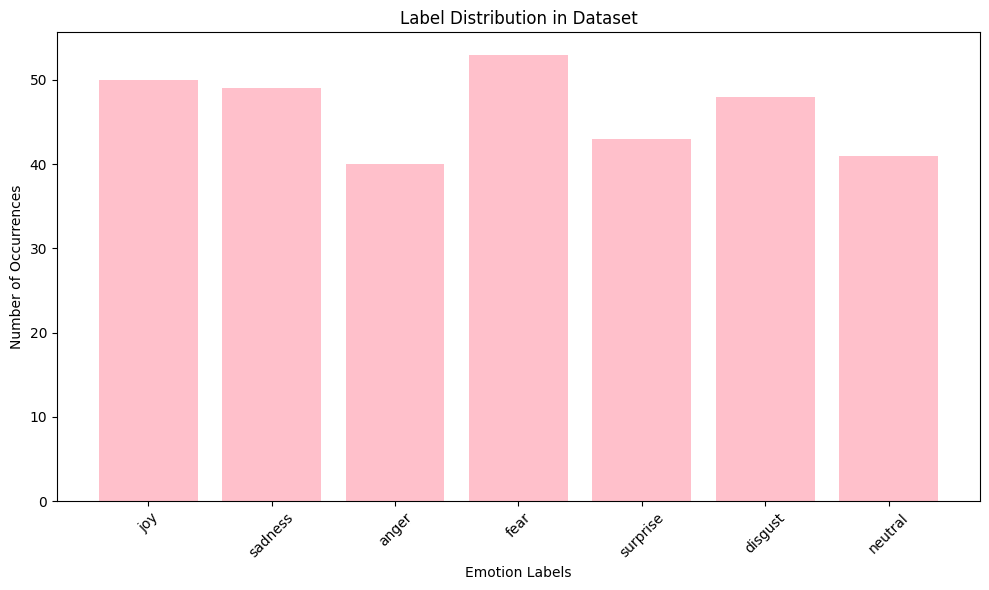

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Example dummy values
y_true = np.random.randint(0, 2, size=(100, 7))
emotion_cols = ['joy', 'sadness', 'anger', 'fear', 'surprise', 'disgust', 'neutral']

label_counts = np.sum(y_true, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(emotion_cols, label_counts.tolist(), color='pink')
plt.xlabel('Emotion Labels')
plt.ylabel('Number of Occurrences')
plt.title('Label Distribution in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
